# Install Required Packages

Conda was being funky with the python sys.executable, so decided to just import required packages using pip.

In [1]:
!pip install wandb -qU
!pip install torchmetrics -qU
!pip install accelerate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 6.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os

cwd = os.getcwd()
cwd

'/content'

In [3]:
import os
import sys

sys.path.append("/content/drive/MyDrive/harvestnet")

In [4]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import sys

# sys.path.append("../")
from tools.dataset import SkysatLabelled
from tools.config import Config_Resnet

In [5]:
import os
import time
import torch
from torch.utils.data import DataLoader
import torchvision
import wandb
import numpy as np
from torchmetrics import Accuracy, F1Score, AUROC, Precision, Recall
from accelerate import Accelerator
from collections import defaultdict
import cv2

In [6]:
from tools.dataset import SkysatLabelled
from tools.config import Config_Resnet

Login to wandb. might need to make an account.
After creating account, you will get an API passkey, paste back into colab.

In [7]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load Dataset

In [8]:
# -----------------
# CONFIG
# -----------------

config = Config_Resnet()


# Seed
torch.manual_seed(config.seed)
np.random.seed(config.seed)


accelerator = Accelerator(
    log_with="wandb",
    mixed_precision=config.mixed_precision,
)
device = accelerator.device

# Log on each process the small summary:
if accelerator.is_main_process:
    print(f"Training/evaluation parameters:")
    print(config.__dict__)

accelerator.init_trackers(
    config.wandb_project,
    config=config,
    init_kwargs={
        "wandb": {
            "group": config.wandb_group,
            "reinit": True,
            "dir": os.path.join(config.working_dir),
        }
    },
)

LOGGING = True
if LOGGING:
    accelerator.init_trackers(
        config.wandb_project,
        config=config,
        init_kwargs={
            "wandb": {
                "group": config.wandb_group,
                "reinit": True,
                "dir": os.path.join(config.working_dir),
            }
        },
    )


# -----------------
# DATASET
# -----------------
if accelerator.is_main_process:
    print("Loading datasets")
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((224, 224)),
        # torchvision.transforms.RandomHorizontalFlip(),
        # torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.412, 0.368, 0.326], std=[0.110, 0.097, 0.098]
        ),  # our dataset vals
    ]
)

wandb: Currently logged in as: dumeixiang1 (dukedeeplearning). Use `wandb login --relogin` to force relogin
wandb: WARNING Path harvest-piles/wandb/ wasn't writable, using system temp directory.


Training/evaluation parameters:
{'working_dir': 'harvest-piles', 'dataset_path': 'dataset', 'wandb_project': 'harvest-piles', 'wandb_group': 'resnet50', 'seed': 2023, 'scheduler': 'one_cycle_lr', 'lr': 0.001, 'optimizer': 'madgrad', 'mixed_precision': 'fp16', 'num_train_epochs': 30, 'batch_size': 32}


Loading datasets


Mount google drive in order to load big skysat_images folder. Regular zipped upload did not work. Make sure you complete the following:
1. upload to your google drive a zipped version of skysat_images. make sure to name is skysat_images.zip
2. run the following code
3. after successfully unzipping skysat_images, make sure to move it to Dataset folder

# Preprocess CSVs to Remove Broken Images

Train Dataset

In [9]:
import pandas as pd
import os

IMAGE_DIR = "/content/drive/MyDrive/harvestnet/Dataset/skysat_images"
TRAIN_FILE = "/content/drive/MyDrive/harvestnet/Dataset/train.csv"
TEST_FILE = "/content/drive/MyDrive/harvestnet/Dataset/test.csv"

df = pd.read_csv(TRAIN_FILE, usecols=["filename"])
df.reset_index(inplace=True, drop=True)
examples = df["filename"]
print(examples)

0         746.tif
1        6025.tif
2       16965.tif
3       22851.tif
4       52469.tif
          ...    
5526    17146.tif
5527     8998.tif
5528     4463.tif
5529    17192.tif
5530    12217.tif
Name: filename, Length: 5531, dtype: object


In [ ]:
# # Get broken images
# broken_images = []
# for index in range(len(examples)):
#     try:
#         path = os.path.join(IMAGE_DIR, examples[index])
#         image = cv2.imread(path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     except:
#         print(examples[index])
#         broken_images.append(examples[index])

23290.tif
3976.tif
1576.tif
38208.tif


In [10]:
broken_images = ["6014.tif"]

In [ ]:
print(len(broken_images))

1


Remove Them

In [11]:
# get the original train and test csv
train = pd.read_csv(TRAIN_FILE)
train = train.iloc[:, 1:]

test = pd.read_csv(TEST_FILE)
test = test.iloc[:, 1:]

print(train.shape)
print(test.shape)

(5531, 13)
(1383, 13)


In [12]:
# filter the broken images from train and test csv
train_filtered = train[~train["filename"].isin(broken_images)]
train_filtered.reset_index(inplace=True)

test_filtered = test[~test["filename"].isin(broken_images)]
test_filtered.reset_index(inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

(5531, 14)
(1383, 14)


In [13]:
for index, row in train_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print(index)
        break

for index, row in test_filtered.iterrows():
    if int(row["filename"][:-4]) != index:
        print(index)
        break


# drop level_0 and index columns
train_filtered.drop(["index"], axis=1, inplace=True)
test_filtered.drop(["index"], axis=1, inplace=True)

print(train_filtered.shape)
print(test_filtered.shape)

0
0
(5531, 13)
(1383, 13)


In [14]:
# replace the train and test csvs with the filtered versions
train_filtered.to_csv("/content/drive/MyDrive/harvestnet/Dataset/train.csv")
test_filtered.to_csv("/content/drive/MyDrive/harvestnet/Dataset/test.csv")

In [15]:
# LOAD DATASETS
ROOT_PATH = "/content/drive/MyDrive/harvestnet/Dataset/"
train_dataset = SkysatLabelled(
    os.path.join(ROOT_PATH, "train.csv"),  # config.dataset_path
    os.path.join(ROOT_PATH, "skysat_images"),  # config.dataset_path
    transform,
)

test_dataset = SkysatLabelled(
    os.path.join(ROOT_PATH, "test.csv"),  # config.dataset_path
    os.path.join(ROOT_PATH, "skysat_images"),  # config.dataset_path
    transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

Check the content of both datasets to confirm we are looking at the correct data.

In [ ]:
# check how many images are in train_dataset
print(len(train_dataset))
print(len(test_dataset))

5531
1383


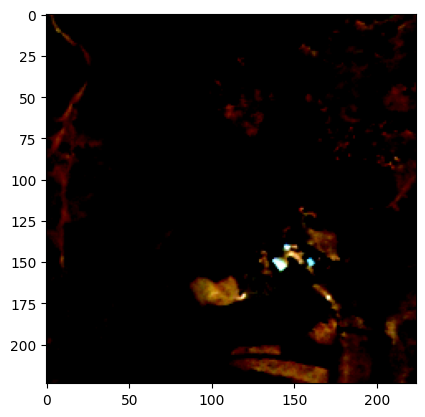

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(train_dataset[1999][0].permute(1, 2, 0))

# Train DyResnet

At this point, hopefully the model can be trained.

In [16]:
# code is inheritated from paper"REVISITING DYNAMIC CONVOLUTION VIA MATRIX DECOMPOSITION"
# "https://github.com/liyunsheng13/dcd with adjustment to fit current data and paramas

import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.nn.parameter import Parameter
import torch
import torch.nn.functional as F
import torch.optim as optim

if accelerator.is_main_process:
    print("Loading Dymodel")

model_urls = {
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False
    )


class Hsigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(Hsigmoid, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return F.relu6(x + 3.0, inplace=self.inplace) / 3.0


class SEModule_small(nn.Module):
    def __init__(self, channel):
        super(SEModule_small, self).__init__()
        self.fc = nn.Sequential(nn.Linear(channel, channel, bias=False), Hsigmoid())

    def forward(self, x):
        y = self.fc(x)
        return x * y


class DYCls(nn.Module):
    def __init__(self, inp, oup):
        super(DYCls, self).__init__()
        self.dim = 32
        self.cls = nn.Linear(inp, oup)
        self.cls_q = nn.Linear(inp, self.dim, bias=False)
        self.cls_p = nn.Linear(self.dim, oup, bias=False)

        mid = 32

        self.fc = nn.Sequential(
            nn.Linear(inp, mid, bias=False),
            SEModule_small(mid),
        )
        self.fc_phi = nn.Linear(mid, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(mid, oup, bias=False)
        self.hs = Hsigmoid()
        self.bn1 = nn.BatchNorm1d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

    def forward(self, x):
        # r = self.cls(x)
        b, c = x.size()
        y = self.fc(x)
        dy_phi = self.fc_phi(y).view(b, self.dim, self.dim)
        dy_scale = self.hs(self.fc_scale(y)).view(b, -1)

        r = dy_scale * self.cls(x)

        x = self.cls_q(x)
        x = self.bn1(x)
        x = self.bn2(torch.matmul(dy_phi, x.view(b, self.dim, 1)).view(b, self.dim)) + x
        x = self.cls_p(x)

        return x + r


class conv_basic_dy(nn.Module):
    def __init__(self, inplanes, planes, stride):
        super(conv_basic_dy, self).__init__()

        self.conv = conv3x3(inplanes, planes, stride)
        self.dim = int(math.sqrt(inplanes * 4))
        squeeze = max(inplanes * 4, self.dim**2) // 16
        if squeeze < 4:
            squeeze = 4

        self.q = nn.Conv2d(inplanes, self.dim, 1, stride, 0, bias=False)

        self.p = nn.Conv2d(self.dim, planes, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

        self.avg_pool = nn.AdaptiveAvgPool2d(2)

        self.fc = nn.Sequential(
            nn.Linear(inplanes * 4, squeeze, bias=False),
            SEModule_small(squeeze),
        )
        self.fc_phi = nn.Linear(squeeze, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(squeeze, planes, bias=False)
        self.hs = Hsigmoid()

    def forward(self, x):
        r = self.conv(x)
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c * 4)
        y = self.fc(y)
        phi = self.fc_phi(y).view(b, self.dim, self.dim)
        scale = self.hs(self.fc_scale(y)).view(b, -1, 1, 1)
        r = scale.expand_as(r) * r

        out = self.bn1(self.q(x))
        _, _, h, w = out.size()

        out = out.view(b, self.dim, -1)
        out = self.bn2(torch.matmul(phi, out)) + out
        out = out.view(b, -1, h, w)
        out = self.p(out) + r

        return out


class BasicBlock_dy(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock_dy, self).__init__()

        self.inplanes = inplanes
        self.planes = planes
        self.conv1 = conv_basic_dy(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = conv_basic_dy(planes, planes, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        b, c, _, _ = x.size()
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class conv_dy(nn.Module):
    def __init__(self, inplanes, planes, kernel_size, stride, padding):
        super(conv_dy, self).__init__()
        self.conv = nn.Conv2d(
            inplanes,
            planes,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.dim = int(math.sqrt(inplanes))
        squeeze = max(inplanes, self.dim**2) // 16

        self.q = nn.Conv2d(inplanes, self.dim, 1, stride, 0, bias=False)

        self.p = nn.Conv2d(self.dim, planes, 1, 1, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(self.dim)
        self.bn2 = nn.BatchNorm1d(self.dim)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Linear(inplanes, squeeze, bias=False),
            SEModule_small(squeeze),
        )
        self.fc_phi = nn.Linear(squeeze, self.dim**2, bias=False)
        self.fc_scale = nn.Linear(squeeze, planes, bias=False)
        self.hs = Hsigmoid()

    def forward(self, x):
        r = self.conv(x)
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y)
        phi = self.fc_phi(y).view(b, self.dim, self.dim)
        scale = self.hs(self.fc_scale(y)).view(b, -1, 1, 1)
        r = scale.expand_as(r) * r

        out = self.bn1(self.q(x))
        _, _, h, w = out.size()

        out = out.view(b, self.dim, -1)
        out = self.bn2(torch.matmul(phi, out)) + out
        out = out.view(b, -1, h, w)
        out = self.p(out) + r
        return out


class Bottleneck_dy(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck_dy, self).__init__()
        self.inplanes = inplanes
        self.planes = planes
        self.conv1 = conv_dy(inplanes, planes, 1, 1, 0)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv_dy(planes, planes, 3, stride, 1)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv_dy(planes, planes * 4, 1, 1, 0)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet_dcd(nn.Module):
    def __init__(self, block, layers, num_classes=1, dropout=0.1):  #
        self.inplanes = 64
        super(ResNet_dcd, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        classifier = []
        if dropout is not None:
            classifier.append(nn.Dropout(p=dropout))
        classifier.append(DYCls(512 * block.expansion, num_classes))
        # classifier.append(nn.Linear(512 * block.expansion, num_classes))
        self.classifier = nn.Sequential(*classifier)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2.0 / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.inplanes,
                    planes * block.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


def resnet50_dcd(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet_dcd(Bottleneck_dy, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet50"]))
    return model


net = resnet50_dcd(pretrained=False, num_classes=1)

Loading Dymodel


## Training

In [17]:
# specify the device for computation
#############################################
# your code here
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition
net = net.to(device)

Run on GPU...


In [18]:
# params concluded from personal experience with Resnet 50

import torch.nn as nn
import torch.optim as optim
import time

INITIAL_LR = 0.01

MOMENTUM = 0.9

REG = 1e-4

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(
    net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
)
# scheduler = optim.lr_scheduler.StepLR(
#     optimizer, step_size=10, gamma=0.1
# )## from paper

In [ ]:
# Total number of training epochs
EPOCHS = 50

# The folder where the trained model is saved
CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"

# Start the training/validation process
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)

for epoch in range(EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()  # Convert input data to torch.FloatTensor
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        print(outputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            print(outputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


流式输出内容被截断，只能显示最后 5000 行内容。
        [ 0.1163],
        [ 0.2489],
        [-0.2283],
        [ 0.1251],
        [ 0.1164],
        [ 0.0164],
        [-3.2939],
        [-0.2361],
        [-0.0154],
        [-0.2273],
        [ 0.1916],
        [ 0.2589],
        [ 0.2199]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.1127],
        [-0.3804],
        [ 0.2455],
        [ 0.1171],
        [ 0.2222],
        [ 0.0654],
        [ 0.1212],
        [ 0.2061],
        [ 0.0295],
        [-0.5011],
        [-0.1872],
        [ 0.0463],
        [ 0.1794],
        [-3.3346],
        [-0.2857],
        [ 0.1898],
        [ 0.1997],
        [ 0.2395],
        [ 0.2545],
        [ 0.1828],
        [ 0.2053],
        [ 0.0095],
        [ 0.0627],
        [ 0.1406],
        [ 0.1814],
        [ 0.2234],
        [ 0.1769],
        [ 0.0567],
        [ 0.0600],
        [ 0.1830],
        [-0.3805],
        [ 0.1970]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 0.2045],
        [ 0.157

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


流式输出内容被截断，只能显示最后 5000 行内容。
        [-3.4442],
        [ 2.0116],
        [-1.2928],
        [ 3.4205],
        [ 4.2647],
        [-4.1738],
        [-1.3811],
        [ 1.6726],
        [ 3.7685],
        [ 0.3499],
        [ 2.8566],
        [-1.0896]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[ 1.4218],
        [-1.9320],
        [ 0.6771],
        [ 2.2915],
        [-2.6376],
        [-5.7317],
        [-3.7911],
        [-3.8200],
        [ 0.8936],
        [ 1.2733],
        [ 3.0908],
        [-0.3926],
        [-1.4380],
        [-0.7022],
        [ 1.1671],
        [-1.5966],
        [ 0.6246],
        [-0.6147],
        [-1.7915],
        [-0.8391],
        [ 2.9387],
        [ 4.4577],
        [-0.4007],
        [-0.7791],
        [-1.4732],
        [ 2.9379],
        [ 2.1242],
        [ 2.2546],
        [ 1.6742],
        [-2.8872],
        [-0.3239],
        [-4.2508]], device='cuda:0', grad_fn=<AddBackward0>)
tensor([[-2.3087],
        [ 1.5887],
        [ 1.145

In [ ]:
EPOCHS = 50


CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"

# Start the training/validation process
best_val_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("=" * 50)

for epoch in range(EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()  # Convert input data to torch.FloatTensor
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        print(outputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            print(outputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

In [19]:
import torch
import os
import time


EPOCHS = 50


CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"


best_val_acc = 0
current_learning_rate = INITIAL_LR
previous_best_val_acc = 0

print("==> Training starts!")
print("=" * 50)

checkpoint_path = os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint["state_dict"])
    starting_epoch = checkpoint["epoch"] + 1
    current_learning_rate = checkpoint["lr"]
    best_val_acc = previous_best_val_acc
    print("Loaded checkpoint '{}' (epoch {})".format(checkpoint_path, starting_epoch))
else:
    print("No checkpoint found at '{}'".format(checkpoint_path))
    starting_epoch = 0

for epoch in range(starting_epoch, EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Loaded checkpoint '/content/drive/MyDrive/harvestnet/DyResnet_best.pth' (epoch 17)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 18, Training Loss: 0.6006, Training Accuracy: 0.6596
Validation Loss: nan, Validation Accuracy: 0.6349
Epoch 18 completed in 2343.45 seconds
Saving best model...

Epoch 19, Training Loss: 0.5954, Training Accuracy: 0.6662
Validation Loss: nan, Validation Accuracy: 0.6146
Epoch 19 completed in 59.53 seconds

Epoch 20, Training Loss: 0.5878, Training Accuracy: 0.6735
Validation Loss: nan, Validation Accuracy: 0.6283
Epoch 20 completed in 59.44 seconds

Epoch 21, Training Loss: 0.5879, Training Accuracy: 0.6671
Validation Loss: nan, Validation Accuracy: 0.6233
Epoch 21 completed in 59.23 seconds

Epoch 22, Training Loss: 0.5781, Training Accuracy: 0.6798
Validation Loss: nan, Validation Accuracy: 0.6067
Epoch 22 completed in 59.21 seconds

Epoch 23, Training Loss: 0.5783, Training Accuracy: 0.6747
Validation Loss: nan, Validation Accuracy: 0.6312
Epoch 23 completed in 59.11 seconds

Epoch 24, Training Loss: 0.5697, Training Accuracy: 0.6865
Validation Loss: nan, Validation Accuracy:

In [21]:
# Best one aound 39, params inherited from dynamic convolution paper

import torch.nn as nn
import torch.optim as optim
import time

INITIAL_LR = 0.1

MOMENTUM = 0.9

REG = 1e-4

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.SGD(
    net.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG
)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  ## from paper

In [23]:
import torch
import os
import time

EPOCHS = 100


CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"

best_val_acc = 0
current_learning_rate = INITIAL_LR
previous_best_val_acc = 0

print("==> Training starts!")
print("=" * 50)

checkpoint_path = os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint["state_dict"])
    starting_epoch = checkpoint["epoch"] + 1
    current_learning_rate = checkpoint["lr"]
    best_val_acc = previous_best_val_acc
    print("Loaded checkpoint '{}' (epoch {})".format(checkpoint_path, starting_epoch))
else:
    print("No checkpoint found at '{}'".format(checkpoint_path))
    starting_epoch = 0

for epoch in range(starting_epoch, EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()  # Convert input data to torch.FloatTensor
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Loaded checkpoint '/content/drive/MyDrive/harvestnet/DyResnet_best.pth' (epoch 27)
Epoch 28, Training Loss: 0.6460, Training Accuracy: 0.5907
Validation Loss: nan, Validation Accuracy: 0.6023
Epoch 28 completed in 59.72 seconds
Saving best model...

Epoch 29, Training Loss: 0.6277, Training Accuracy: 0.6196
Validation Loss: nan, Validation Accuracy: 0.5792
Epoch 29 completed in 59.69 seconds

Epoch 30, Training Loss: 0.6167, Training Accuracy: 0.6415
Validation Loss: nan, Validation Accuracy: 0.6305
Epoch 30 completed in 59.32 seconds
Saving best model...

Epoch 31, Training Loss: 0.5985, Training Accuracy: 0.6608
Validation Loss: nan, Validation Accuracy: 0.6580
Epoch 31 completed in 59.74 seconds
Saving best model...

Epoch 32, Training Loss: 0.5824, Training Accuracy: 0.6785
Validation Loss: nan, Validation Accuracy: 0.6797
Epoch 32 completed in 59.69 seconds
Saving best model...

Epoch 33, Training Loss: 0.5623, Training Accuracy: 0.7010
Validation Loss: nan, V

KeyboardInterrupt: 

In [24]:
# param from the harvest paper to train on the pretrained model

from torch.optim import lr_scheduler

INITIAL_LR = 1e-3
MOMENTUM = 0.9
WEIGHT_DECAY = 1e-4
EPOCHS = 100

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam with default parameters)
optimizer = optim.Adam(net.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (One Cycle scheduler)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=INITIAL_LR, total_steps=EPOCHS)

In [ ]:
import torch
import os
import time


EPOCHS = 100


CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"


best_val_acc = 0.7050
current_learning_rate = INITIAL_LR
previous_best_val_acc = 0

print("==> Training starts!")
print("=" * 50)

checkpoint_path = os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint["state_dict"])
    starting_epoch = checkpoint["epoch"] + 1
    current_learning_rate = checkpoint["lr"]
    best_val_acc = previous_best_val_acc
    print("Loaded checkpoint '{}' (epoch {})".format(checkpoint_path, starting_epoch))
else:
    print("No checkpoint found at '{}'".format(checkpoint_path))
    starting_epoch = 0

for epoch in range(starting_epoch, EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()  # Convert input data to torch.FloatTensor
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Loaded checkpoint '/content/drive/MyDrive/harvestnet/DyResnet_best.pth' (epoch 40)
Epoch 41, Training Loss: 0.2743, Training Accuracy: 0.8756
Validation Loss: nan, Validation Accuracy: 0.6753
Epoch 41 completed in 60.50 seconds
Saving best model...

Epoch 42, Training Loss: 0.1832, Training Accuracy: 0.9233
Validation Loss: nan, Validation Accuracy: 0.6696
Epoch 42 completed in 60.92 seconds

Epoch 43, Training Loss: 0.1127, Training Accuracy: 0.9577
Validation Loss: nan, Validation Accuracy: 0.6631
Epoch 43 completed in 60.50 seconds

Epoch 44, Training Loss: 0.0840, Training Accuracy: 0.9693
Validation Loss: nan, Validation Accuracy: 0.6580
Epoch 44 completed in 60.36 seconds

Epoch 45, Training Loss: 0.0779, Training Accuracy: 0.9693
Validation Loss: nan, Validation Accuracy: 0.6587
Epoch 45 completed in 60.79 seconds

Epoch 46, Training Loss: 0.0649, Training Accuracy: 0.9756
Validation Loss: nan, Validation Accuracy: 0.6565
Epoch 46 completed in 60.44 seconds


In [19]:
# param from the harvest paper to train on the pretrained model

from torch.optim import lr_scheduler

INITIAL_LR = 1e-2
MOMENTUM = 0.9  # Momentum for SGD optimizer
WEIGHT_DECAY = 1e-3  # Weight decay for L2 regularization due to overfitting
EPOCHS = 100  # Total number of training epochs

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer (Adam with default parameters)
optimizer = optim.Adam(net.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler (One Cycle scheduler)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=INITIAL_LR, total_steps=EPOCHS)

In [ ]:
import torch
import os
import time


EPOCHS = 100


CHECKPOINT_FOLDER = "/content/drive/MyDrive/harvestnet"


best_val_acc = 0.7050
current_learning_rate = INITIAL_LR
previous_best_val_acc = 0

print("==> Training starts!")
print("=" * 50)

checkpoint_path = os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth")
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint["state_dict"])
    starting_epoch = checkpoint["epoch"] + 1
    current_learning_rate = checkpoint["lr"]
    best_val_acc = previous_best_val_acc
    print("Loaded checkpoint '{}' (epoch {})".format(checkpoint_path, starting_epoch))
else:
    print("No checkpoint found at '{}'".format(checkpoint_path))
    starting_epoch = 0

for epoch in range(starting_epoch, EPOCHS):
    start_time = time.time()

    net.train()
    running_loss = 0
    total_examples = 0
    correct_examples = 0

    for inputs, labels, _ in train_loader:
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs.squeeze(), labels.squeeze())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct = predicted.eq(labels).sum().item()
        correct_examples += correct
        total_examples += inputs.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print(
        f"Epoch {epoch+1}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc:.4f}"
    )

    # Validation phase
    net.eval()
    val_loss = 0
    total_examples = 0
    correct_examples = 0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs = inputs.float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), targets.squeeze())
            val_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct_examples += predicted.eq(targets).sum().item()
            total_examples += targets.size(0)

    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = correct_examples / total_examples
    print(
        f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {avg_val_acc:.4f}"
    )

    end_time = time.time()  # End time of the epoch
    epoch_duration = end_time - start_time
    print(f"Epoch {epoch+1} completed in {epoch_duration:.2f} seconds")

    # Save the model checkpoint if it's the best so far
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        print("Saving best model...")
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        state = {
            "state_dict": net.state_dict(),
            "epoch": epoch,
            "lr": current_learning_rate,
        }
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, "DyResnet_best.pth"))

    print("")

print("=" * 50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")

==> Training starts!
Loaded checkpoint '/content/drive/MyDrive/harvestnet/DyResnet_best.pth' (epoch 56)
Epoch 57, Training Loss: 0.3464, Training Accuracy: 0.8414
Validation Loss: nan, Validation Accuracy: 0.6638
Epoch 57 completed in 4007.52 seconds
Saving best model...

Epoch 58, Training Loss: 0.3729, Training Accuracy: 0.8255
Validation Loss: nan, Validation Accuracy: 0.6999
Epoch 58 completed in 60.95 seconds
Saving best model...

Epoch 59, Training Loss: 0.3434, Training Accuracy: 0.8416
Validation Loss: nan, Validation Accuracy: 0.6797
Epoch 59 completed in 60.53 seconds

Epoch 60, Training Loss: 0.3454, Training Accuracy: 0.8384
Validation Loss: nan, Validation Accuracy: 0.6739
Epoch 60 completed in 60.36 seconds

Epoch 61, Training Loss: 0.3192, Training Accuracy: 0.8566
Validation Loss: nan, Validation Accuracy: 0.6847
Epoch 61 completed in 60.11 seconds

Epoch 62, Training Loss: 0.3167, Training Accuracy: 0.8545
Validation Loss: nan, Validation Accuracy: 0.6471
Epoch 62 comp